# hello operator 

## have a good monday. 
## your Faisal, Peter and Junbo

In [9]:
import numpy as np
import struct
import os
import tensorflow as tf
import time

from matplotlib import pyplot as plt

### helpers

In [2]:
class MNIST_GAN():
    def __init__(self, directory):
        self._directory = directory
        
        self._data = self._load_binaries("train-images-idx3-ubyte")
        self._data = np.append(self._data, self._load_binaries("t10k-images-idx3-ubyte"), axis = 0)
        self._data = ((self._data / 255) * 2) - 1
        self._data = self._data.reshape([-1, 28, 28, 1])

    
    def _load_binaries(self, file_name):
        path = os.path.join(self._directory, file_name)
        
        with open(path, 'rb') as fd:
            check, items_n = struct.unpack(">ii", fd.read(8))

            if "images" in file_name and check == 2051:
                height, width = struct.unpack(">II", fd.read(8))
                images = np.fromfile(fd, dtype = 'uint8')
                return np.reshape(images, (items_n, height, width))
            else:
                raise ValueError("Not a MNIST file: " + path)
    
    def get_batch(self, batch_size):
        samples_n = self._data.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
            
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = self._data[random_indices]
        
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off]
            
def feed_forward_layer(x, target_size, normalize = False, activation_function = None):
    print("     Forward-Layer:" + str(x.shape))
    
    fan_in = int(x.shape[-1])
    
    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [target_size], tf.float32, var_init)
    
    activation = tf.matmul(x, weights) + biases
    
    if normalize:
        activation = batch_norm(activation, [0])
    
    return activation_function(activation) if callable(activation_function) else activation


def conv_layer(x, kernel_quantity, kernel_size, stride_size, normalize = False, activation_function = False):
    print("     Conv-Layer:" + str(x.shape))
    depth = x.shape[-1]
    fan_in = int(x.shape[1] * x.shape[2])
    
    if activation_function == tf.nn.relu or activation_function == tf.nn.leaky_relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    kernels = tf.get_variable("kernels", [kernel_size, kernel_size, depth, kernel_quantity], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [kernel_quantity], initializer = var_init)
    
    activation = tf.nn.conv2d(x, kernels, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    
    if normalize:
        activation = batch_norm(activation, [0, 1, 2])
    
    return activation_function(activation) if callable(activation_function) else activation

def deconv_layer(x, kernel_quantity, kernel_size, output_shape,stride_size, normalize = False, activation_function = False):
    print("     Deconv-Layer:" + str(x.shape))
    depth = x.shape[-1]
    fan_in = int(x.shape[1] * x.shape[2])
    
    if activation_function == tf.nn.relu or activation_function == tf.nn.leaky_relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    filters = tf.get_variable("filters", [kernel_size, kernel_size, kernel_quantity,depth], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [kernel_quantity], initializer = var_init)
    
    activation = tf.nn.conv2d_transpose(x, filters, output_shape, strides = [1, stride_size, stride_size, 1], padding = "SAME") + biases
    
    if normalize:
        activation = batch_norm(activation, [0, 1, 2])
    
    return activation_function(activation) if callable(activation_function) else activation




def back_conv_layer(x, target_shape, kernel_size, stride_size, normalize = False, activation_function = False):
    pass


def flatten(x):
    size = int(np.prod(x.shape[1:]))
    return tf.reshape(x, [-1, size])


def _pop_batch_norm(x, pop_mean, pop_var, offset, scale):
    return tf.nn.batch_normalization(x, pop_mean, pop_var, offset, scale, 1e-6)

def _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale):
    decay = 0.99
    
    dependency_1 = tf.assign(pop_mean, pop_mean * decay + mean * (1 - decay))
    dependency_2 = tf.assign(pop_var, pop_var * decay + var * (1 - decay))

    with tf.control_dependencies([dependency_1, dependency_2]):
        return tf.nn.batch_normalization(x, mean, var, offset, scale, 1e-6)

def batch_norm(x, axes):
    depth = x.shape[-1]
    mean, var = tf.nn.moments(x, axes = axes)
    
    var_init = tf.constant_initializer(0.0)
    offset = tf.get_variable("offset", [depth], tf.float32, var_init)
    var_init = tf.constant_initializer(1.0)
    scale = tf.get_variable("scale", [depth], tf.float32, var_init)
    
    pop_mean = tf.get_variable("pop_mean", [depth], initializer = tf.zeros_initializer(), trainable = False)
    pop_var = tf.get_variable("pop_var", [depth], initializer = tf.ones_initializer(), trainable = False)
    
    return tf.cond(
        is_training,
        lambda: _batch_norm(x, pop_mean, pop_var, mean, var, offset, scale),
        lambda: _pop_batch_norm(x, pop_mean, pop_var, offset, scale)
    )


In [3]:
directory = "."
GAN = MNIST_GAN(directory)

# Parameters

In [4]:
batch_size = 32
z_dim = 50
lr = 0.0004
beta1 = 0.5
epochs = 2
generator_dim = [64, 32, 16]
discriminator_dim = [8, 16, 32]
real_images_n = 32
fake_images_n = 32

# Graph

In [7]:
tf.reset_default_graph()

with tf.variable_scope("generator"):
    print("generator")

    ## Placeholders
    z_input = tf.placeholder(tf.float32,[None, 50])
    is_training = tf.placeholder(tf.bool, shape=[])

    # Feed batch into discriminator
    with tf.variable_scope("layer1"):
        fn1 = feed_forward_layer(z_input, 64*4*4 ,normalize = True, activation_function = tf.nn.relu)
        fn1_out = tf.reshape(fn1, [batch_size, 4, 4, 64])
        print("     layer 1 size ",fn1_out.shape)

    with tf.variable_scope("layer2"):
        conv2 = deconv_layer(x = fn1_out, 
                             kernel_quantity = 32, 
                             kernel_size = 5,
                             output_shape = [batch_size, 7,7,32], 
                             stride_size = 2, 
                             normalize = True, activation_function = tf.nn.relu)
        print("     layer 2 size ",conv2.shape)


    with tf.variable_scope("layer3"):
        conv3 = deconv_layer(x = conv2, 
                             kernel_quantity = 16, 
                             kernel_size = 5,
                             output_shape = [batch_size, 14,14,16], 
                             stride_size = 2, 
                             normalize = True, activation_function = tf.nn.relu)
        print("     layer 3 size ",conv3.shape)

    with tf.variable_scope("layer4"):
        conv4 = deconv_layer(x = conv3, 
                             kernel_quantity = 1, 
                             kernel_size = 5,
                             output_shape = [batch_size, 28,28,1], 
                             stride_size = 2, 
                             normalize = False, activation_function = tf.nn.tanh)
        print("     layer 4/fake image size ",conv4.shape)
    fake_images = conv4
    

    
with tf.variable_scope("discriminator"):
    print("discriminator")
    trainVars = tf.trainable_variables()
    
    # Generate fake images ...
    # Concatenate real and fake images
    real_images = tf.placeholder(tf.float32, [real_images_n, 28, 28, 1]) 
    real_and_fake_images = tf.concat([fake_images, real_images], 0)
    # Feed batch into discriminator
    # default alpha value for leaky relu is already 0.2
    with tf.variable_scope("layer1"):
        conv1 = conv_layer(x = real_and_fake_images, 
                             kernel_quantity = discriminator_dim[0], 
                             kernel_size = 5,
                             stride_size = 2, 
                             normalize = True, 
                             activation_function = tf.nn.leaky_relu)
        print("     layer 1 size ",conv1.shape)


    with tf.variable_scope("layer2"):
        conv2 = conv_layer(x = conv1, 
                             kernel_quantity = discriminator_dim[1], 
                             kernel_size = 5,
                             stride_size = 2, 
                             normalize = True, 
                             activation_function = tf.nn.leaky_relu)
        print("     layer 2 size ",conv2.shape)


    with tf.variable_scope("layer3"):
        conv3 = conv_layer(x = conv2, 
                             kernel_quantity = discriminator_dim[2], 
                             kernel_size = 5,
                             stride_size = 2, 
                             normalize = True, 
                             activation_function = tf.nn.leaky_relu)
        print("     layer 3 size ",conv3.shape)

    with tf.variable_scope("layer4"):
        conv3_flat = tf.reshape(conv3, [batch_size * 2,4*4*32]) 
        output = feed_forward_layer(x = conv3_flat, 
                                    target_size = 1,  
                                    normalize = False, 
                                    activation_function = tf.nn.sigmoid)
        print("     output size ",output.shape)
    
# Generate labels
with tf.variable_scope("target_values"):
    dis_desired = tf.concat([tf.zeros([fake_images_n, 1]), tf.ones([real_images_n, 1])], 0) 
    gen_desired = tf.ones([fake_images_n, 1])

trainable_variables = tf.trainable_variables()

# Get weights of the generator and the distinguisher independently
dis_variables = [var for var in trainable_variables if "discriminator" in var.name] 
gen_variables = [var for var in trainable_variables if "generator" in var.name]

print(dis_variables)
print(gen_variables)
# ... define respective losses and two different optimizers ...
dis_optimizer = tf.train.AdamOptimizer(lr, beta1)
dis_cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=dis_desired, logits = output))
tf.summary.scalar('dis_loss', dis_cross_entropy)

gen_optimizer = tf.train.AdamOptimizer(lr, beta1)
gen_cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=gen_desired, logits = output[:fake_images_n]))
tf.summary.scalar('gen_loss', gen_cross_entropy)

dis_training_step = dis_optimizer.minimize(dis_cross_entropy, var_list = dis_variables) 
gen_training_step = gen_optimizer.minimize(gen_cross_entropy, var_list = gen_variables)

merged_summaries = tf.summary.merge_all()

generator
     Forward-Layer:(?, 50)
     layer 1 size  (32, 4, 4, 64)
     Deconv-Layer:(32, 4, 4, 64)
     layer 2 size  (32, 7, 7, 32)
     Deconv-Layer:(32, 7, 7, 32)
     layer 3 size  (32, 14, 14, 16)
     Deconv-Layer:(32, 14, 14, 16)
     layer 4/fake image size  (32, 28, 28, 1)
discriminator
     Conv-Layer:(64, 28, 28, 1)
     layer 1 size  (64, 14, 14, 8)
     Conv-Layer:(64, 14, 14, 8)
     layer 2 size  (64, 7, 7, 16)
     Conv-Layer:(64, 7, 7, 16)
     layer 3 size  (64, 4, 4, 32)
     Forward-Layer:(64, 512)
     output size  (64, 1)
[<tf.Variable 'discriminator/layer1/kernels:0' shape=(5, 5, 1, 8) dtype=float32_ref>, <tf.Variable 'discriminator/layer1/biases:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'discriminator/layer1/offset:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'discriminator/layer1/scale:0' shape=(8,) dtype=float32_ref>, <tf.Variable 'discriminator/layer2/kernels:0' shape=(5, 5, 8, 16) dtype=float32_ref>, <tf.Variable 'discriminator/layer2/biases:0' s

# plotting function (stole from team 25. thank you team 25!)

In [6]:
def plot_images(imgs):
    n, h, w, c = imgs.shape
    cols = int(np.sqrt(n))
    rows = int(n / cols) + 1
    fig, axarr = plt.subplots(rows, cols, figsize=(28, 28))
    for index in range(n):
        row = index // cols
        col = index % cols
        ax = axarr[row][col]
        ax.imshow(imgs[index, :, :, 0], cmap='gray')

    # delete empty plots
    for index in range(n, rows*cols):
        row = index // cols
        col = index % cols
        fig.delaxes(axarr[row][col])

    plt.show()

# Train

Initialized!
Epoch 1/2 Iteration: 1 Discriminator Training loss: 0.6981 Generator Training loss: 0.4968 0.0023 sec/step


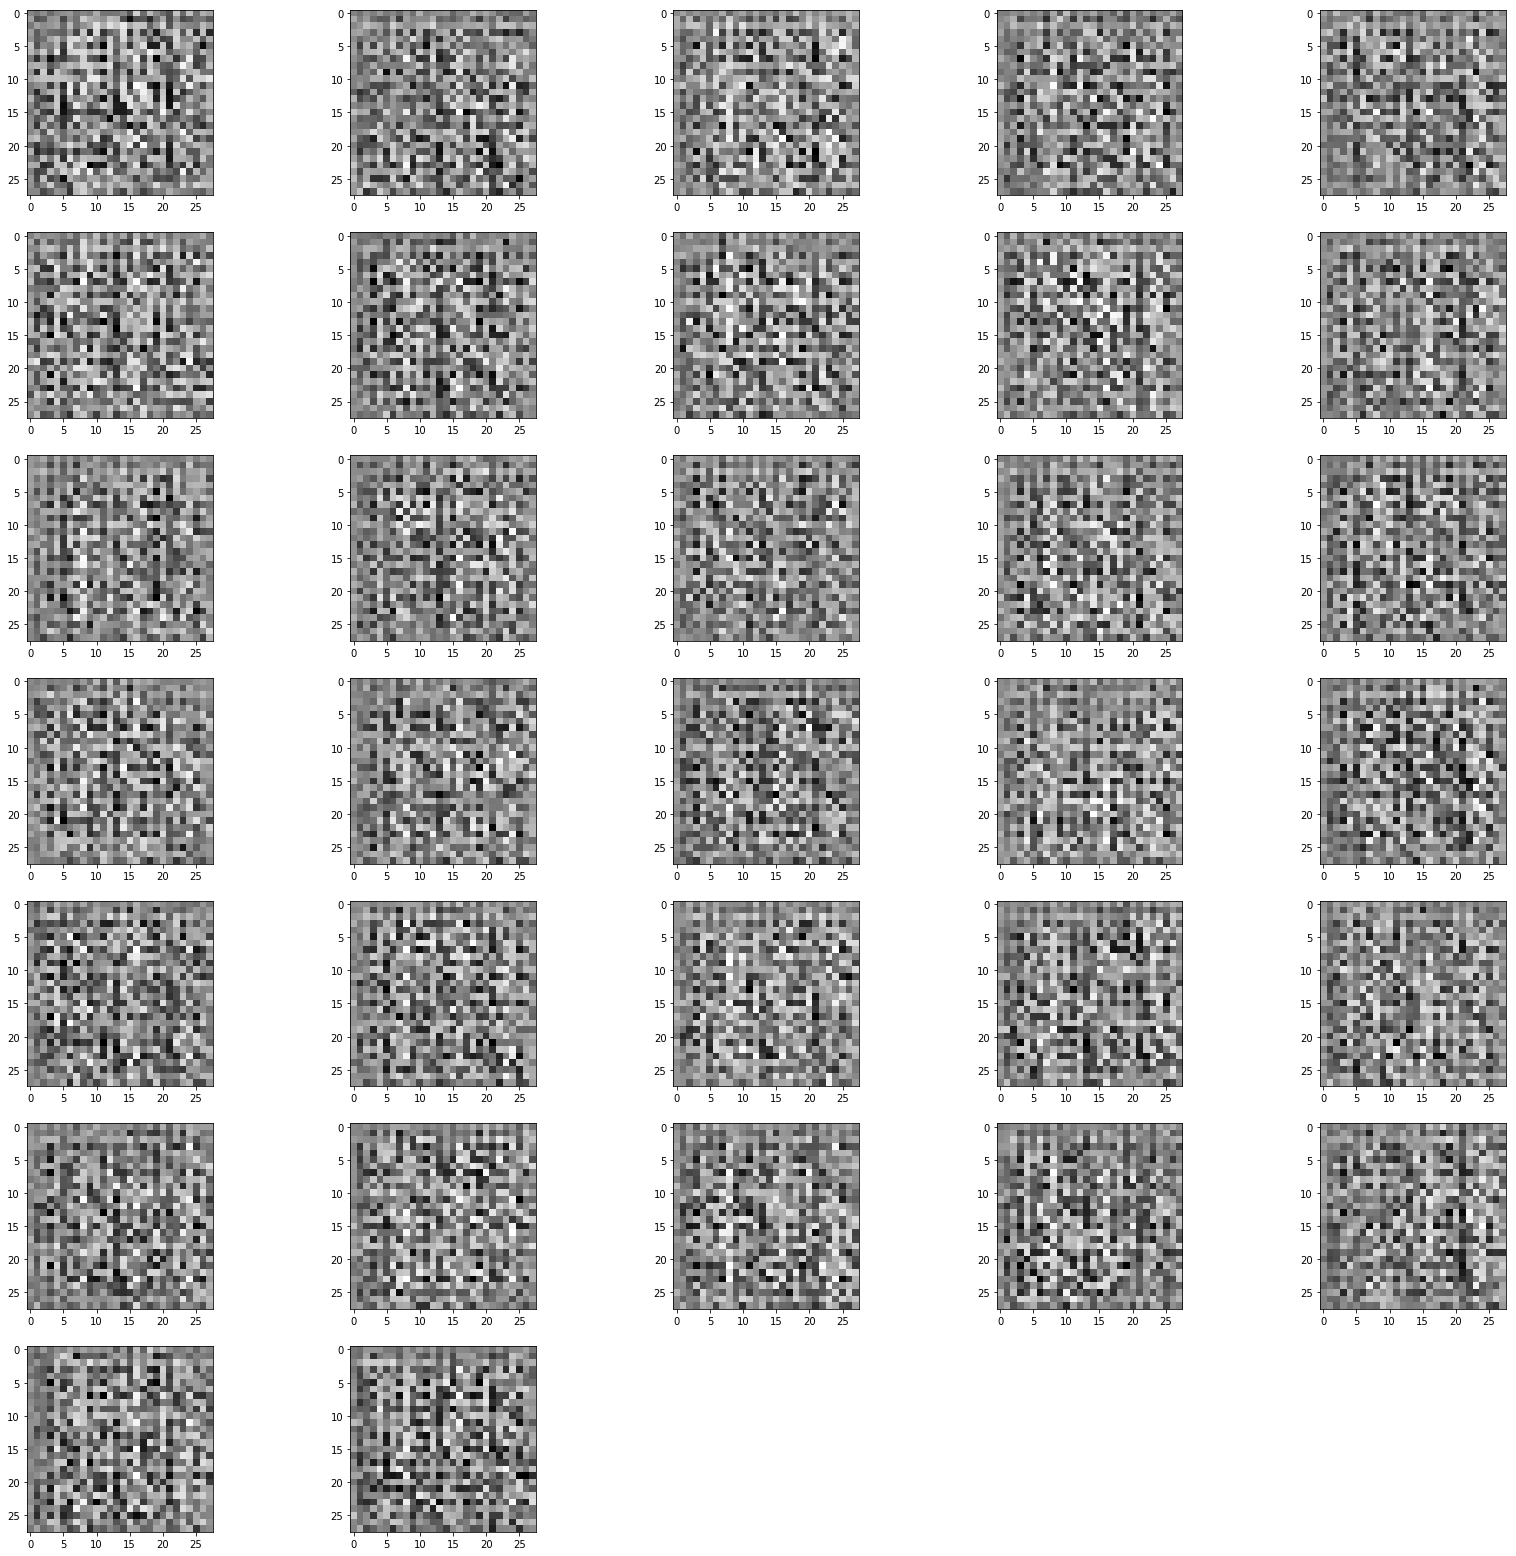

Epoch 1/2 Iteration: 1000 Discriminator Training loss: 0.5038 Generator Training loss: 0.6924 0.0001 sec/step


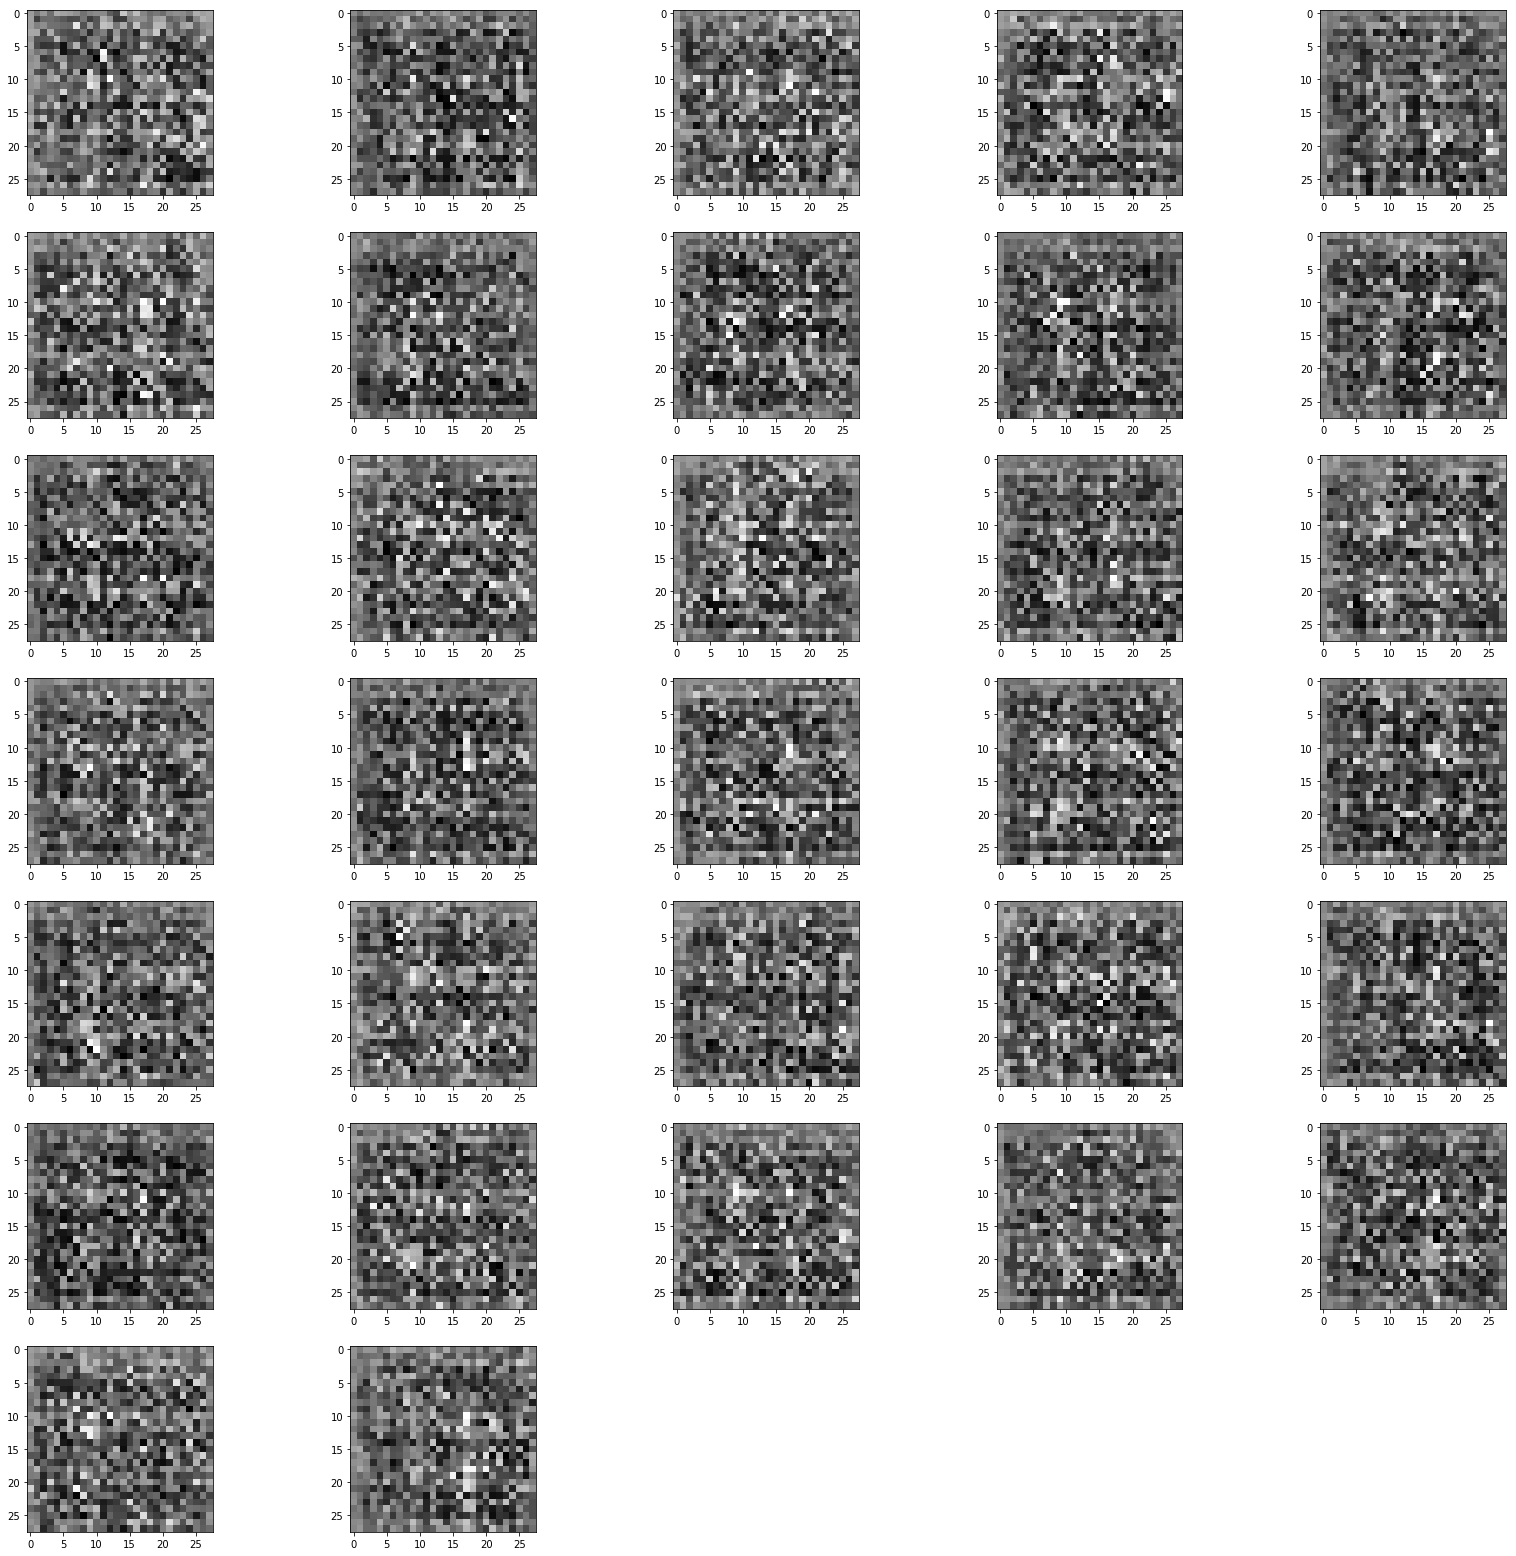

Epoch 1/2 Iteration: 2000 Discriminator Training loss: 0.5035 Generator Training loss: 0.6928 0.0001 sec/step


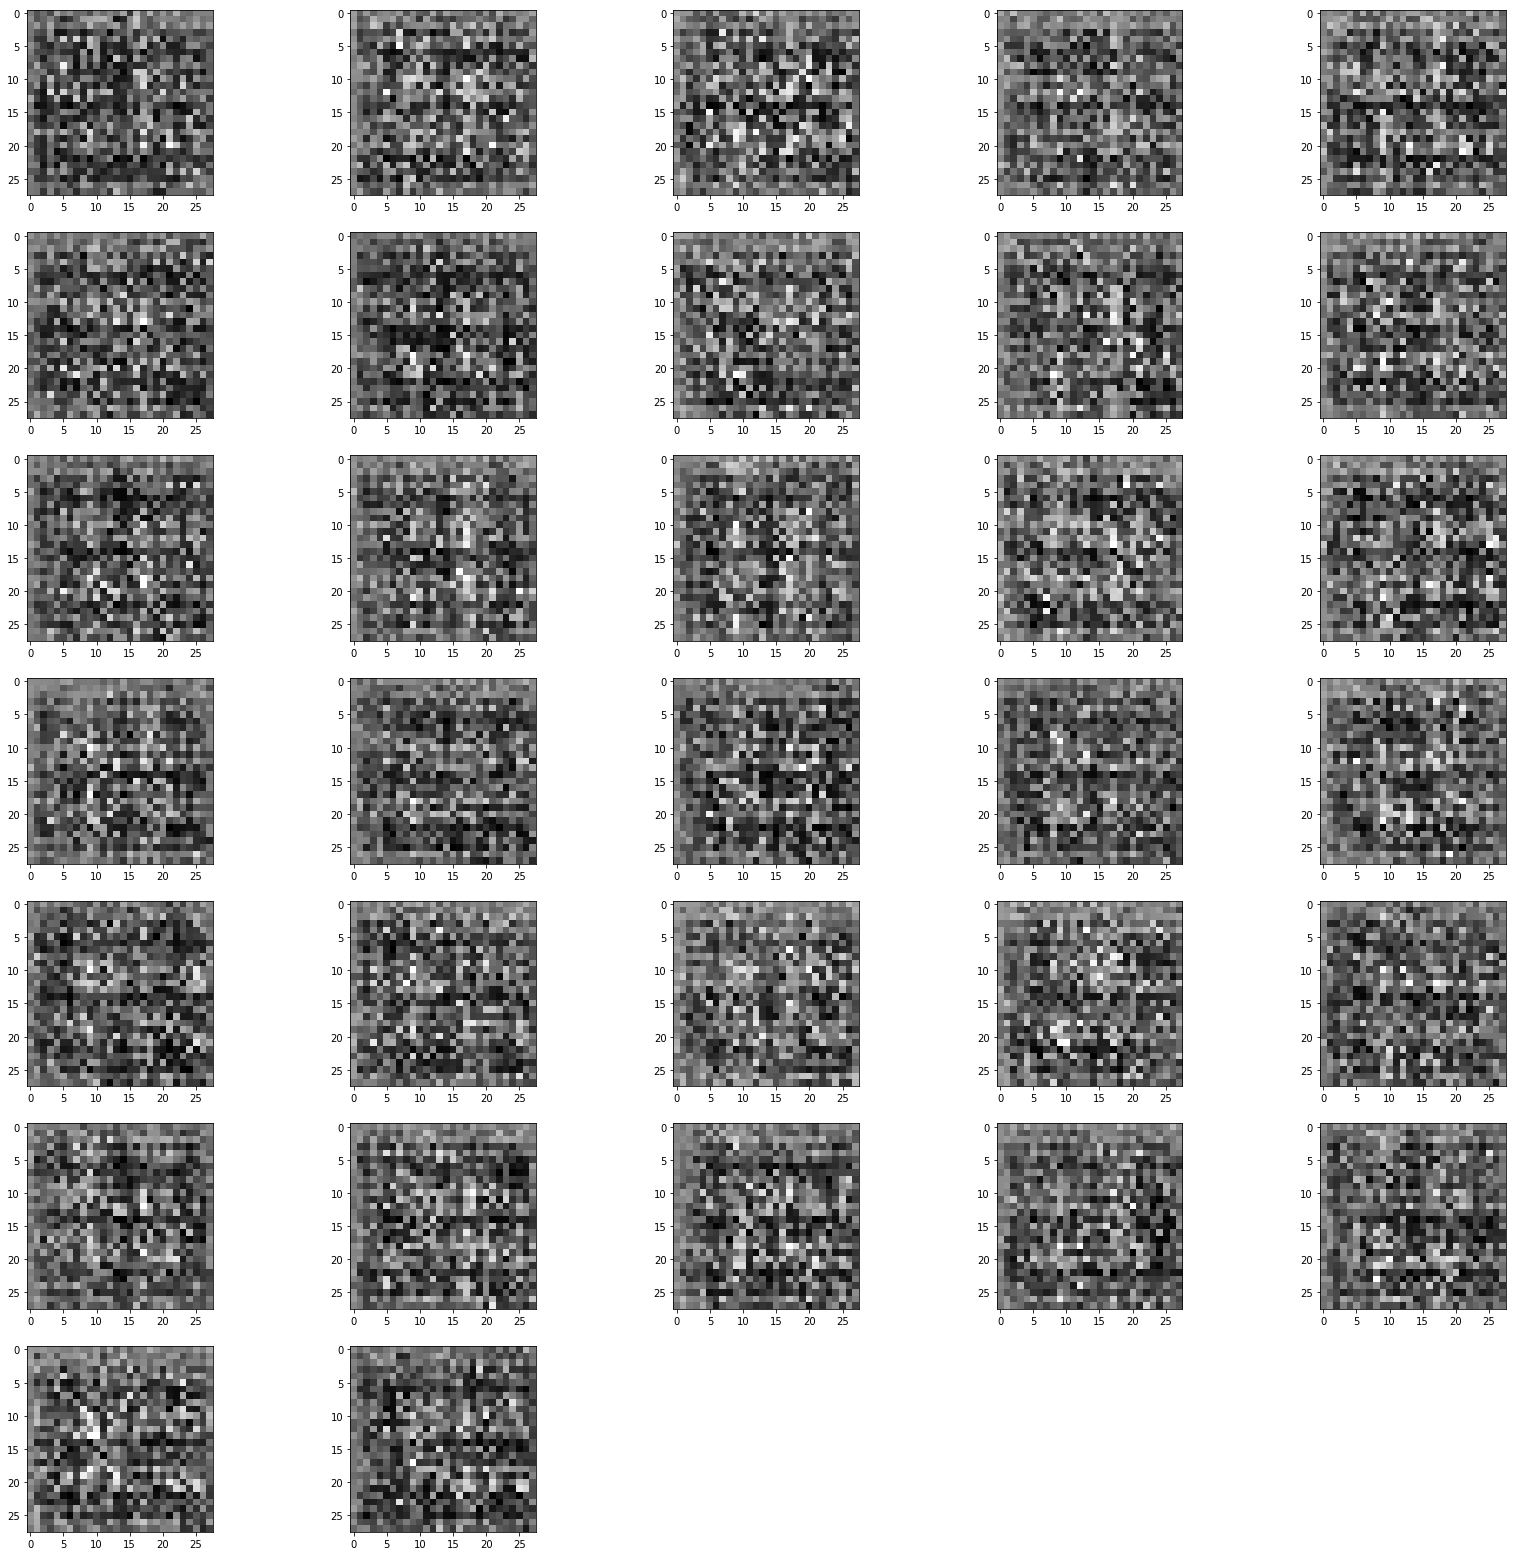

Epoch 2/2 Iteration: 3000 Discriminator Training loss: 0.5034 Generator Training loss: 0.6929 0.0001 sec/step


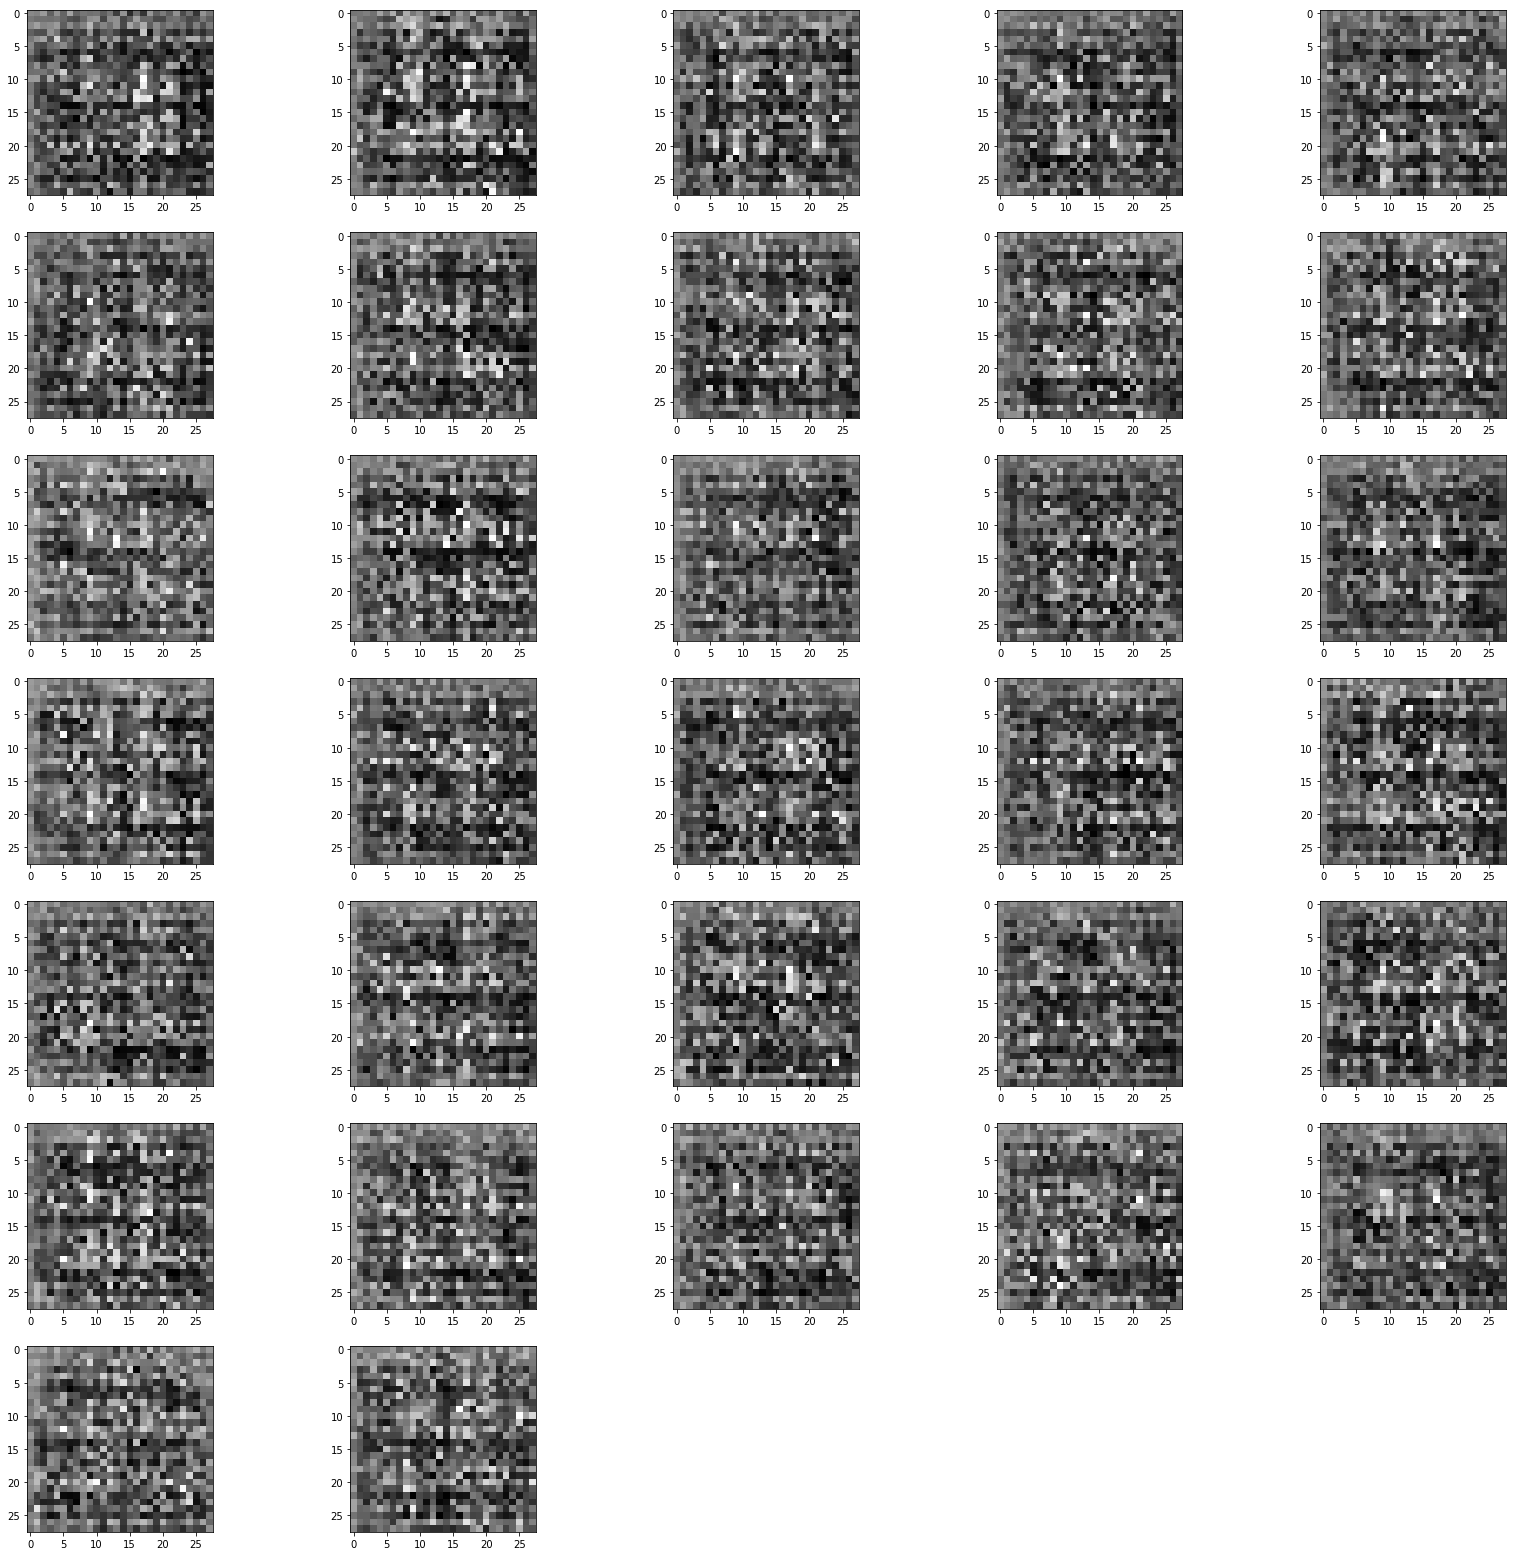

Epoch 2/2 Iteration: 4000 Discriminator Training loss: 0.5034 Generator Training loss: 0.6930 0.0001 sec/step


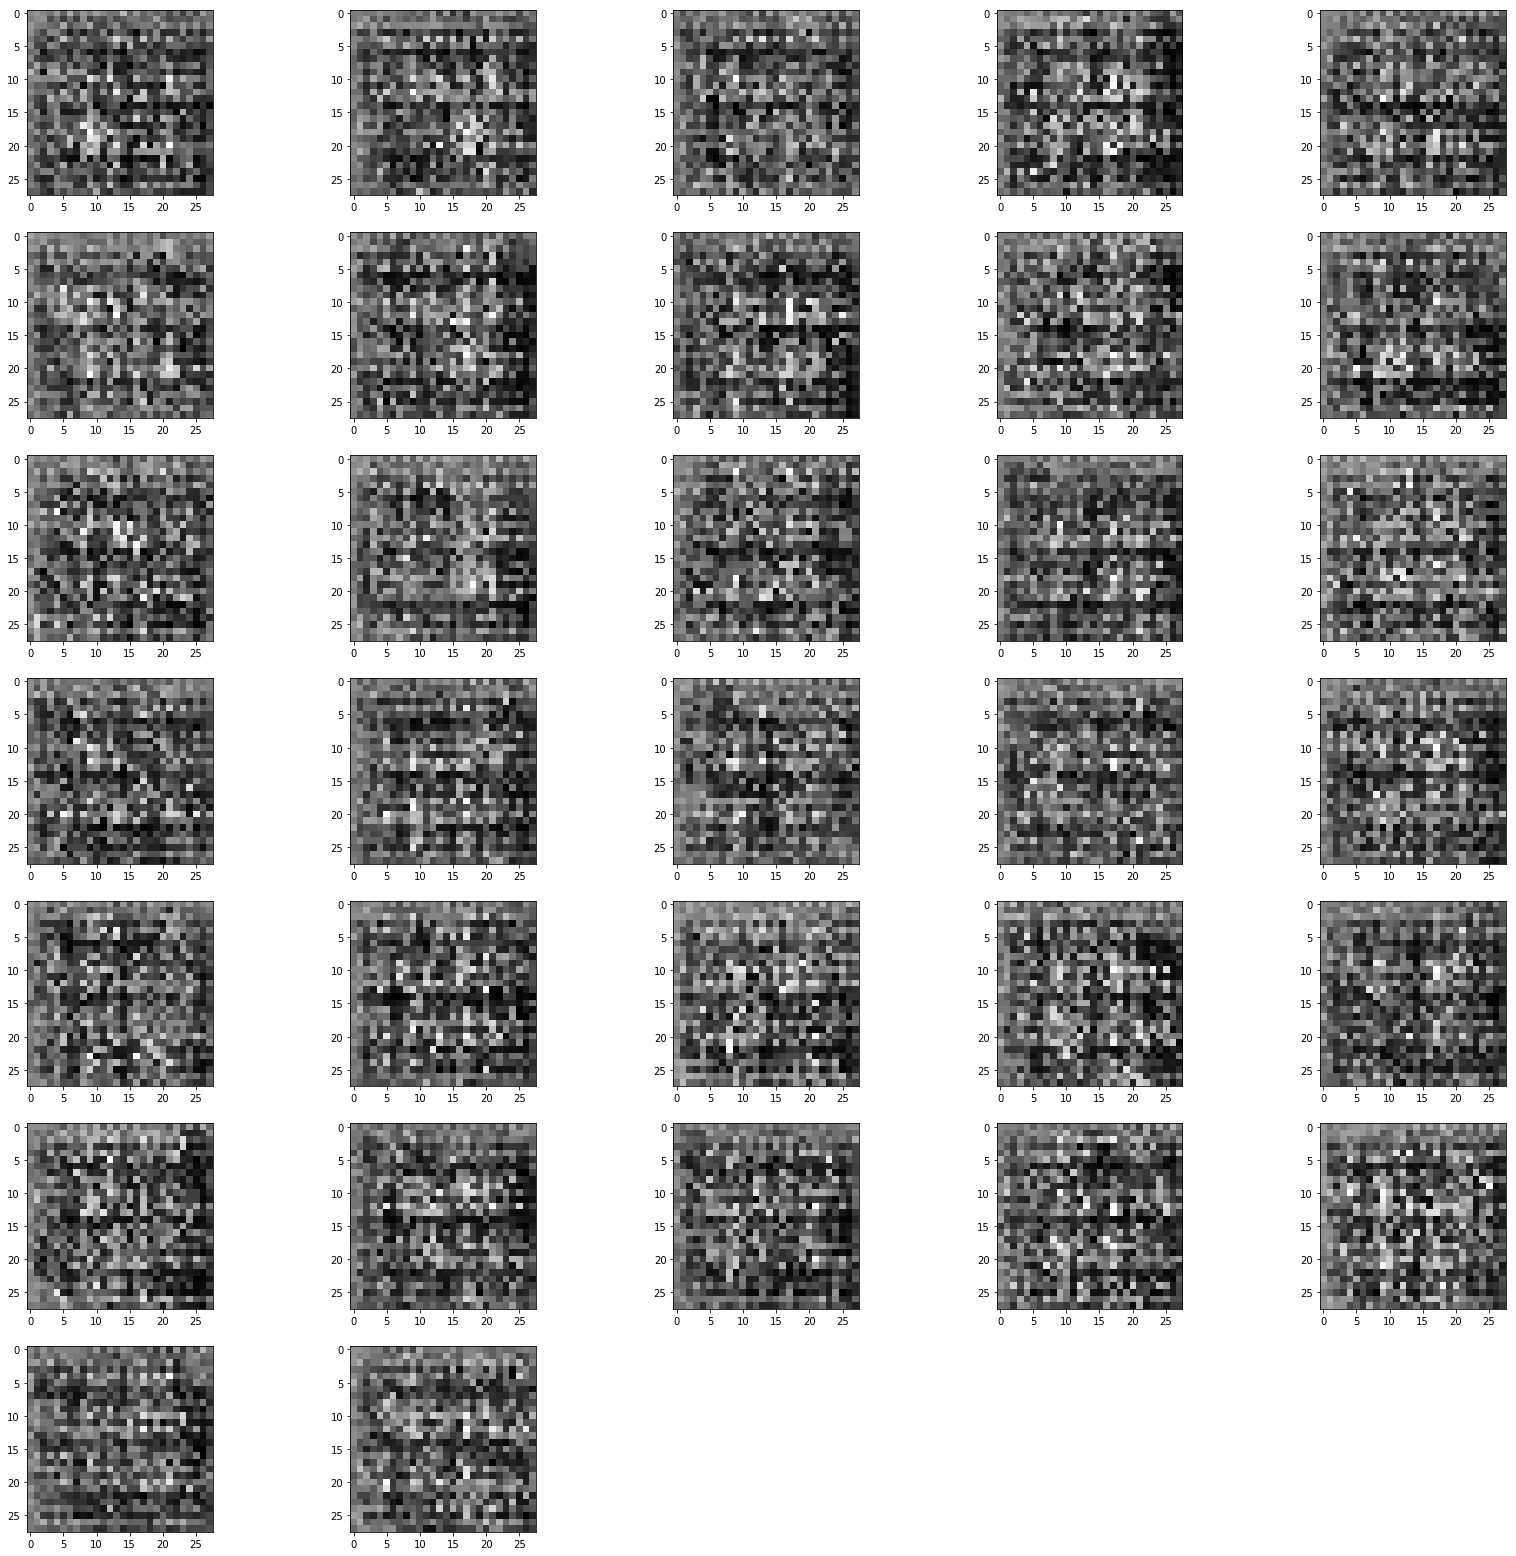

In [8]:
train_writer = tf.summary.FileWriter("./summaries/train", tf.get_default_graph())
display_step = 1000
painting_step = 1000
# save loss for plotting
acc_dis_loss = []
acc_gen_loss = []
    
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    print("Initialized!")
    # document global step for plotting 
    step = 1
    
    
    for epoch in range(1,epochs+1):
        start = time.time()

        for x in GAN.get_batch(batch_size):
            z = np.random.uniform(-1, 1, size=(batch_size, 50))
            goal = [merged_summaries, dis_cross_entropy, gen_cross_entropy,dis_training_step,gen_training_step]
            feed_dict = {z_input: z, 
                         real_images: x,
                         is_training: True
                        }
            summaries, dis_loss, gen_loss, _, _= session.run(
                goal,
                feed_dict = feed_dict
            )
            acc_dis_loss.append(dis_loss)
            acc_gen_loss.append(gen_loss)
            avg_dis_loss = np.mean(acc_dis_loss)
            avg_gen_loss = np.mean(acc_gen_loss)
            end = time.time()

            train_writer.add_summary(summaries, step)
            
            # display loss in text
            if step % display_step == 0 or step == 1:
                print("Epoch {}/{}".format(epoch, epochs),
                      "Iteration: {}".format(step),
                      "Discriminator Training loss: {:.4f}".format(avg_dis_loss),
                      "Generator Training loss: {:.4f}".format(avg_gen_loss),
                      "{:.4f} sec/step".format((end-start)/display_step))
                
            # painting time! paint in every 1000th step
            if step % painting_step == 0 or step == 1:
                goal = conv4
                feed_dict = {z_input: z, 
                             is_training: True
                            }
                img = session.run(goal, feed_dict = feed_dict)
                plot_images(img)
                
            step += 1
            start = time.time()

    
    # Save 
    saver.save(session, "./weights/", global_step = step)



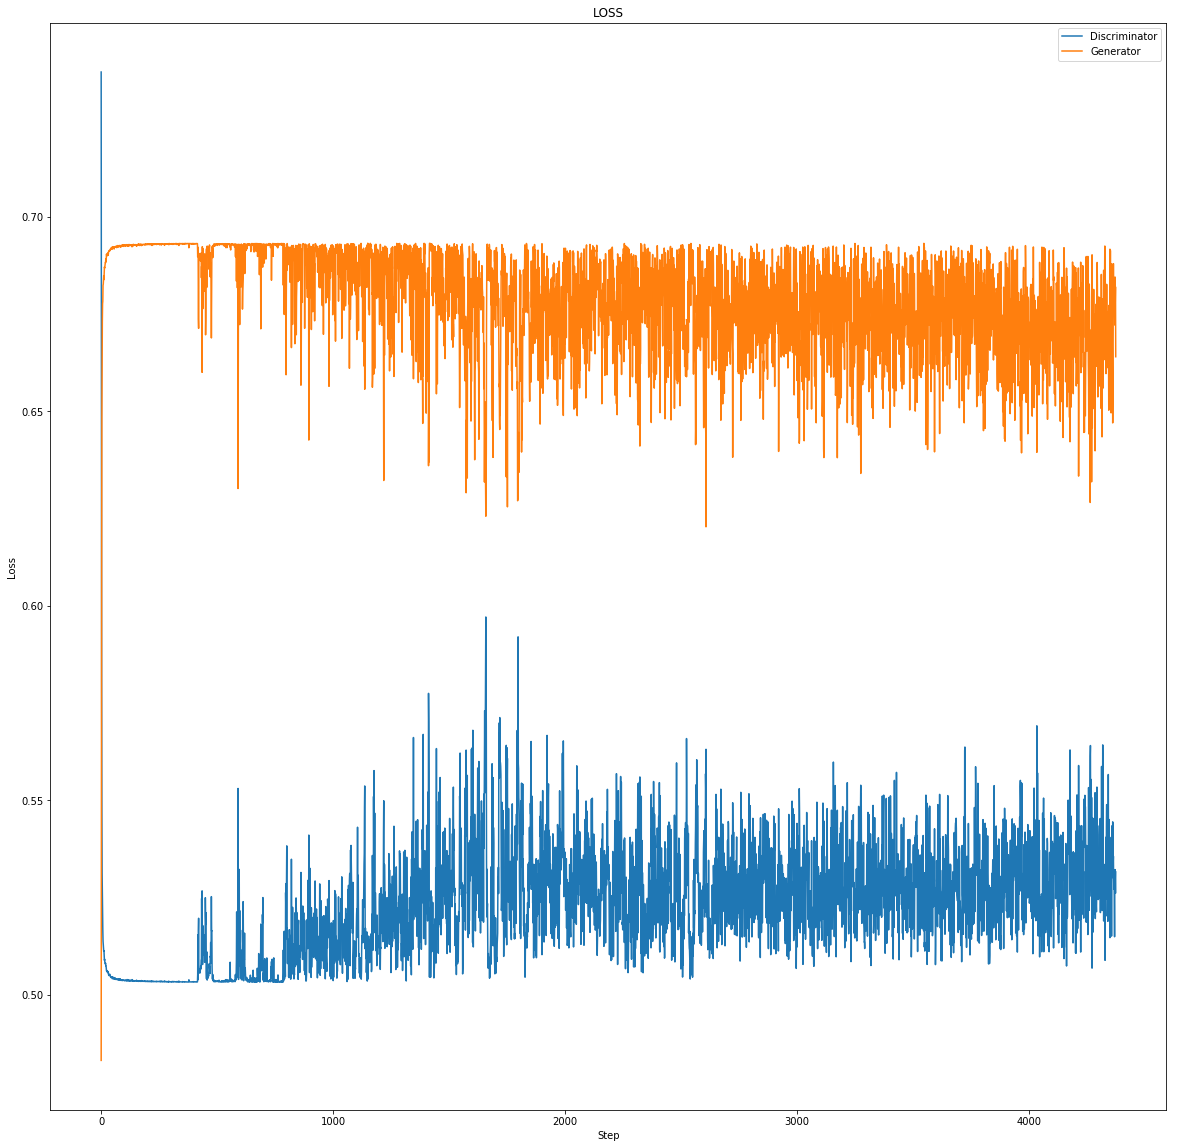

In [33]:
fig = plt.figure(figsize=(20,20))
ax  = fig.add_subplot(111)
ax.set_title('LOSS')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.plot(acc_dis_loss, label='Discriminator')
ax.plot(acc_gen_loss, label='Generator')
ax.legend()
plt.show()